## Pricing American Put Option with Longstaff-Schwartz Algorithm

In [1]:
import numpy as np
import plotly.graph_objects as go

### Geometric Brownian Motion

Assume the price of the underlying $X = {X(t): 0 \leq t \leq T}$ follows Geometric Brownian motion, i.e. $X$ follows the SDE
$$
dX_t = r X_t dt + \sigma X_t dW_t \nonumber
$$

The underlying price $X$ at discrete time points could be simulated by
$$
X_{t_n} = X_0 \exp\{\sum_{i=1}^n((r-\frac{1}{2} \sigma^2)(\delta t) +  \sigma \phi_i \sqrt{\delta t})\} \nonumber
$$

In [2]:
# parameters
np.random.seed(2024)
r = 0.02
sigma = 0.15
s0 = 1.0
T = 6 # months
N = 50
time_steps = 120 # days

In [3]:
# function to generate GBM paths
def gbm(S0:float, T:float, sigma:float, r:float, time_steps:int, num_realisations:int):
    delta_t = T / time_steps
    # each column represents a realisation
    phi = np.random.normal(size = (time_steps, num_realisations)) # default standard normal
    ret = (r - 0.5*sigma**2)*delta_t + sigma*phi*np.sqrt(delta_t)
    # add one row with 0 at the top, so the realisations can start at S_0
    ret_cumsum = np.concatenate((np.array([[0]*num_realisations]), np.cumsum(ret, axis = 0)), axis = 0)
    price_paths = S0*np.exp(ret_cumsum)
    return price_paths

paths = gbm(s0, T, sigma, r, time_steps, N)

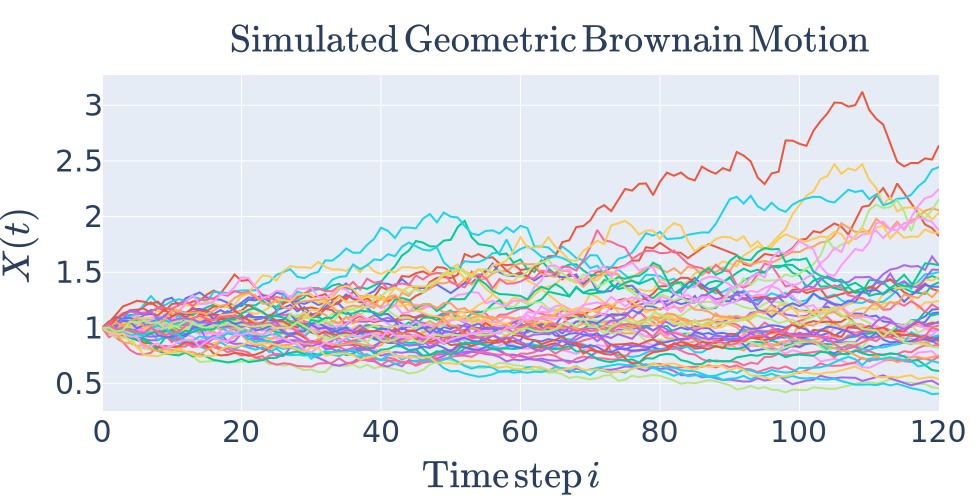

In [4]:
fig = go.Figure()
for path in paths.T:
    fig.add_trace(
            go.Scatter(
                    x = np.arange(0,121),
                    y = path,
                    mode='lines',
                    showlegend = False)                    
    )
fig.update_layout(
        title = dict(
            text=r'$\huge{\text{Simulated Geometric Brownain Motion}}$',
            x = 0.6,
            y = 0.9
        ),
        font=dict(size=30),
        xaxis_title = r'$\huge{\text{Time step } i}$',
        yaxis_title = r'$\huge{X(t)}$',
        legend=dict(
        x=0.51,
        y=1,
        traceorder="normal",
        font=dict(
            family="Arial",
            size=25,
            color="black")
        ),
        paper_bgcolor='rgba(0,0,0,0)',
        margin=dict(l=20, r=20, t=75, b=20),
        autosize=False,
        width=980,
        height=500
)
fig.show(renderer="svg")

### American Put Option

For a fixed strike $K$, the put option exercise payoff $Y = {Y(t): 0 \leq t \leq T}$ at any discrete $t_i$ is
$$
Y(t_i) = (K -X(t_i))^+
$$

In [5]:
K = 1.1

In [6]:
def intrinsic_value(x):
    return np.maximum(K - x, 0)

### Least Square Monte Carlo

From Snell envelope, the option price is given by
$$
U(t) = \max \left(Y(t), \mathbb{E}^\mathbb{Q} \left[\frac{U(t + 1)}{B(t + 1)} \middle| \mathcal{F}_t \right] B(t) \right) \nonumber
$$
which under discrete time and constant $r$, 
\begin{align}
C(t_i) &= \mathbb{E}^\mathbb{Q} \left[U(t_{i + 1}) \frac{B(t_i) }{B(t_{i + 1})} \middle| \mathcal{F}_{t_i} \right] \nonumber \\
&= e^{-r(t_{i + 1} - t_{i})} \mathbb{E}^\mathbb{Q} \left[U(t_{i + 1}) \middle| \mathcal{F}_{t_i} \right] \nonumber
\end{align}

At time $t_n$,
\begin{equation}
U(t_n) = Y(t_n) = (K - X(t_n))^+ \nonumber
\end{equation}

At time $t_{n-1}$,
\begin{equation}
U(t_{n - 1}) = \max(Y(t_{n - 1}), C(t_{n - 1})) \nonumber \\
\end{equation}

where the exercising value is
\begin{equation}
Y(t_{n - 1}) = (K - X(t_{n - 1}))^+ \nonumber
\end{equation}
and the holding value is simply a discounted European option
\begin{equation}
V(t_{n-1}, t_n) = e^{-r(t_{n} - t_{n - 1})}  (K - X(t_n))^+ \nonumber
\end{equation}

We can then fit a polynomial function to the simulated $(X(t_{n-1}), V(t_{n-1}, t_n))$ to estimate $C(t_{n-1})$.

In [7]:
discounted_value = np.exp(-r/252) * intrinsic_value(paths[-1, :])
X = paths[-2, :]
fitted = np.polynomial.Laguerre.fit(X, discounted_value, 4)
continuation = fitted(X)

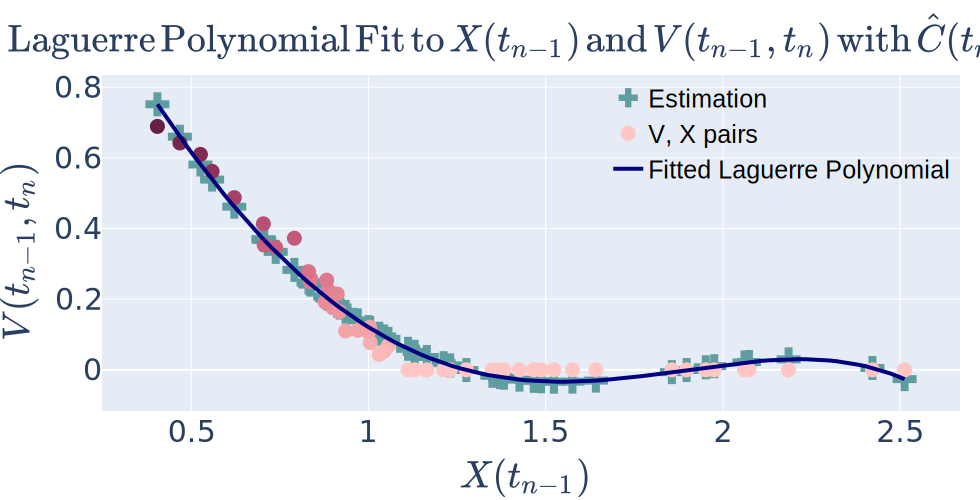

In [8]:
fig = go.Figure()
fig.add_trace(
        go.Scatter(x = X,
                   y = continuation,
                   mode = 'markers',
                   marker_symbol = 'cross',
                   marker = dict(
                        size = 20,
                        color = 'cadetblue'),
                   name = 'Estimation')
)
fig.add_trace(
        go.Scatter(x = X,
                   y = discounted_value,
                   mode = 'markers',
                   marker = dict(
                        size = 15,
                        color = discounted_value,
                        colorscale = 'Burg'),
                   name = 'V, X pairs')
)
fig.add_trace(
        go.Scatter(x = fitted.linspace()[0],
                   y = fitted.linspace()[1],
                   mode='lines',
                   line_color = 'navy', 
                   name = 'Fitted Laguerre Polynomial')
)
fig.update_traces(
line={'width': 4}
)
fig.update_layout(
        title = dict(
            text=r'$\huge{\text{Laguerre Polynomial Fit to }X(t_{n - 1})\text{ and }V(t_{n - 1}, t_{n})\text{ with }\hat{C}(t_{n-1})}$',
            x = 0.6,
            y = 0.9
        ),
        font=dict(size=30),
        xaxis_title = r'$\huge{X(t_{n - 1})}$',
        yaxis_title = r'$\huge{V(t_{n - 1}, t_{n})}$',
        legend=dict(
        x=0.59,
        y=1,
        traceorder="normal",
        font=dict(
            family="Arial",
            size=25,
            color="black")
        ),
        paper_bgcolor='rgba(0,0,0,0)',
        margin=dict(l=20, r=20, t=75, b=20),
        autosize=False,
        width=980,
        height=500
)
fig.show(renderer="svg")

Since the exercising decision is only present when $X$ is in the money (else a rational option buyer will just hold the right to exercise), we can instead use only the ITM points to get a better fit.

In [9]:
exercise = intrinsic_value(X)
itm = exercise > 0
fitted_itm = np.polynomial.Polynomial.fit(X[itm], discounted_value[itm], 3)
continuation = fitted_itm(X)

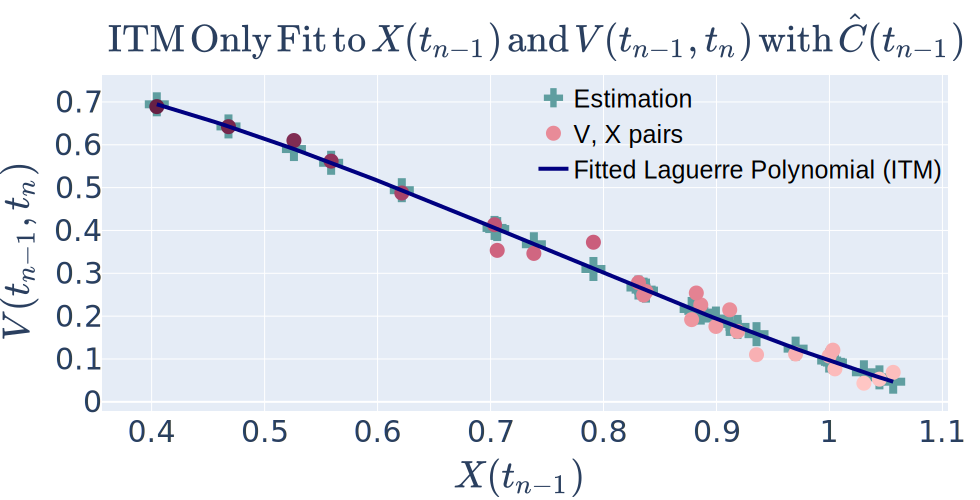

In [10]:
fig = go.Figure()
fig.add_trace(
        go.Scatter(x = X[itm],
                   y = continuation[itm],
                   mode = 'markers',
                   marker_symbol = 'cross',
                   marker = dict(
                        size = 20,
                        color = 'cadetblue'),
                   name = 'Estimation')
)
fig.add_trace(
        go.Scatter(x = X[itm],
                   y = discounted_value[itm],
                   mode = 'markers',
                   marker = dict(
                        size = 15,
                        color = discounted_value[itm],
                        colorscale = 'Burg'),
                   name = 'V, X pairs')
)
fig.add_trace(
        go.Scatter(x = fitted_itm.linspace()[0],
                   y = fitted_itm.linspace()[1],
                   mode='lines',
                   line_color = 'navy', 
                   name = 'Fitted Laguerre Polynomial (ITM)')
)
fig.update_traces(
line={'width': 4}
)
fig.update_layout(
        title = dict(
            text=r'$\huge{\text{ITM Only Fit to }X(t_{n - 1})\text{ and }V(t_{n - 1}, t_{n})\text{ with }\hat{C}(t_{n-1})}$',
            x = 0.6,
            y = 0.9
        ),
        font=dict(size=30),
        xaxis_title = r'$\huge{X(t_{n - 1})}$',
        yaxis_title = r'$\huge{V(t_{n - 1}, t_{n})}$',
        legend=dict(
        x=0.51,
        y=1,
        traceorder="normal",
        font=dict(
            family="Arial",
            size=25,
            color="black")
        ),
        paper_bgcolor='rgba(0,0,0,0)',
        margin=dict(l=20, r=20, t=75, b=20),
        autosize=False,
        width=980,
        height=500
)
fig.show(renderer="svg")

After we obtain an estimate of $C(t_{n - 1})$, we can compare it to $Y(t_{n - 1})$, and determine $U(t_{n - 1})$.

Following the above procedure, we can deduce from $t_n$ to $t_0$ the value of $U(t_i)$ (with $V(t_{n-1}, t_n)$ replaced by $e^{-r(t_{i + 1} - t_{i})} \hat{U}(t_{i + 1})$).

In [11]:
results = []
discounted_value = intrinsic_value(paths[-1, :])

for i in reversed(range(1, paths.shape[0])):
    # discounted U(t_(i+1))
    discounted_value = discounted_value * np.exp(-r/252)

    # find the exercise payoff and the ITM points
    X = paths[i, :]
    exercise = intrinsic_value(X)
    itm = intrinsic_value(X) > 0

    # fit only ITM points
    fitted = np.polynomial.Polynomial.fit(X[itm], discounted_value[itm], 3)
    # estimate the value of continution
    continuation = fitted(X)

    # if exercising gives higher value, replace the discounted continutation value with the exercise value
    ex_idx = itm & (exercise > continuation)
    discounted_value[ex_idx] = exercise[ex_idx]
    
    results.append((discounted_value, X, fitted, continuation, exercise, ex_idx))

In [12]:
# this is to find when the option is not yet exercised and the first exercise time
# for plotting purpose only

exercise_time = []
exercised = [False] * N
exercise_point = []
exercise_time.append(exercised)
exercise_point.append(exercised)
for i in reversed(range(1, paths.shape[0] - 1)):
    exercise = results[i][5]
    exercise_point.append([(x == False) and (y == True) for x, y in zip(exercised, exercise)])
    exercised = [x or y for x, y in zip(exercised, exercise)]
    exercise_time.append(exercised)
    
exercise_time.insert(0, [False] * N) # move the entire series by 1 step to include the exercise point
exercise_point.append([False] * N)
exercise_time = np.array(exercise_time)
exercise_point = np.array(exercise_point)

exercised_paths = np.where(exercise_time == False, paths, None)
exercised_point = np.where(exercise_point == True, paths, None)

exercised_x = []
exercised_y = []
for idx, l in enumerate(exercised_point):
    for p in l:
        if p is not None:
            exercised_x.append(idx)
            exercised_y.append(p)

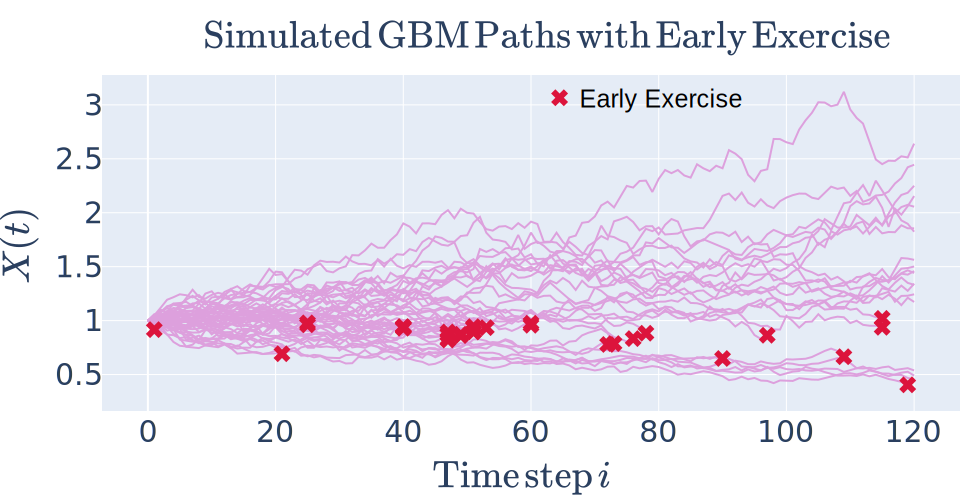

In [13]:
fig = go.Figure()
for path in exercised_paths.T:
    fig.add_trace(
            go.Scatter(
                    x = np.arange(0,121),
                    y = path,
                    mode='lines',
                    line_color = 'plum',
                    showlegend = False)                    
    )

fig.add_trace(
        go.Scatter(x = exercised_x,
                   y = exercised_y,
                   mode = 'markers',
                   marker_symbol = 'x',
                   marker = dict(
                        size = 15,
                        color = 'crimson'),
                   name = 'Early Exercise')
)

fig.update_layout(
        title = dict(
            text=r'$\huge{\text{Simulated GBM Paths with Early Exercise}}$',
            x = 0.6,
            y = 0.9
        ),
        font=dict(size=30),
        xaxis_title = r'$\huge{\text{Time step } i}$',
        yaxis_title = r'$\huge{X(t)}$',
        legend=dict(
        x=0.51,
        y=1,
        traceorder="normal",
        font=dict(
            family="Arial",
            size=25,
            color="black")
        ),
        paper_bgcolor='rgba(0,0,0,0)',
        margin=dict(l=20, r=20, t=75, b=20),
        autosize=False,
        width=980,
        height=500
)
fig.show(renderer="svg")

The option value is just the average of the simulated $U(t_0)$.

In [14]:
american_puts = discounted_value * np.exp(-r/252) # one more discounting to obtain U(t_0)
european_puts = intrinsic_value(paths[-1, :]) * np.exp(-r/252*(paths.shape[0] - 1))
# American option is more valuable than European, when rates are positive
print(round(np.average(american_puts), 4))
print(round(np.average(european_puts), 4))

0.1856
0.1423
